<H1> Glass Classification Dataset </H1>


<H2>Import Libraries /DataSet</H2>

In [28]:
#Importing libraries needed 
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, cross_val_predict,
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

import warnings
# load models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

#Load glass dataset into dataframe
glass_df = pd.read_csv("glass.csv") 

<H2>Data Visualisation and Exploration</H2>

In [29]:
#Display 2 rows for sanity check
glass_df.head(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1


In [30]:
# Explore on the data & features present in the dataset & print the information
print("Total number of dataset", glass_df.shape[0])
print("Total number of features", glass_df.shape[1])
print("Glass Dataset Information")
glass_df.info()
glass_df.dtypes


Total number of dataset 214
Total number of features 10
Glass Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

Class=1, Count=70, Percentage=32.710%
Class=2, Count=76, Percentage=35.514%
Class=3, Count=17, Percentage=7.944%
Class=5, Count=13, Percentage=6.075%
Class=6, Count=9, Percentage=4.206%
Class=7, Count=29, Percentage=13.551%
2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64


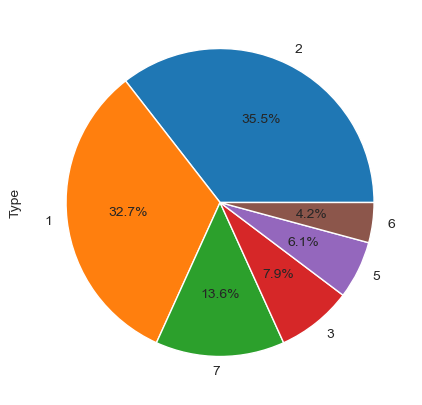

In [31]:
# summarize the class distribution
target = glass_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
    
    #Checking data distribution for heart disease - target variable
glass_df['Type'].value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=10)
print(glass_df['Type'].value_counts())


<h3>There are 214 rows and data for all target type is imbalanced. Type 1 & 2 covers almost 67% of the dataset. There is no data available for target type 4 . All the data seems to be float(numeric) value except target variable</h3>

In [32]:
#Checking data distribution for Glass - Numerical variable
glass_df.describe()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


<h3>The features are not on the same scale. For example Si has a mean of 72.65 while Fe has a mean value of 0.057. Features should be on the same scale </h3> 

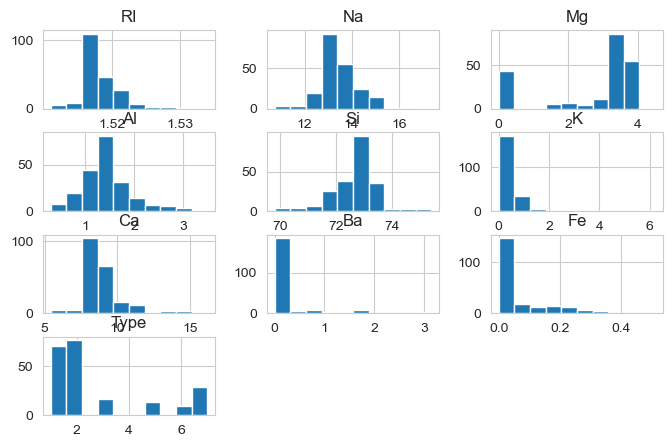

In [33]:
# create histograms of all variables
glass_df.hist()
# show the plot
plt.rcParams["figure.figsize"] = (50,50)
plt.show()

<h3>We can observe that certain dataset have a Gaussian-like distribution and others have exponential or bimodal distribution.</h3>

(214, 10)


<Figure size 900x900 with 0 Axes>

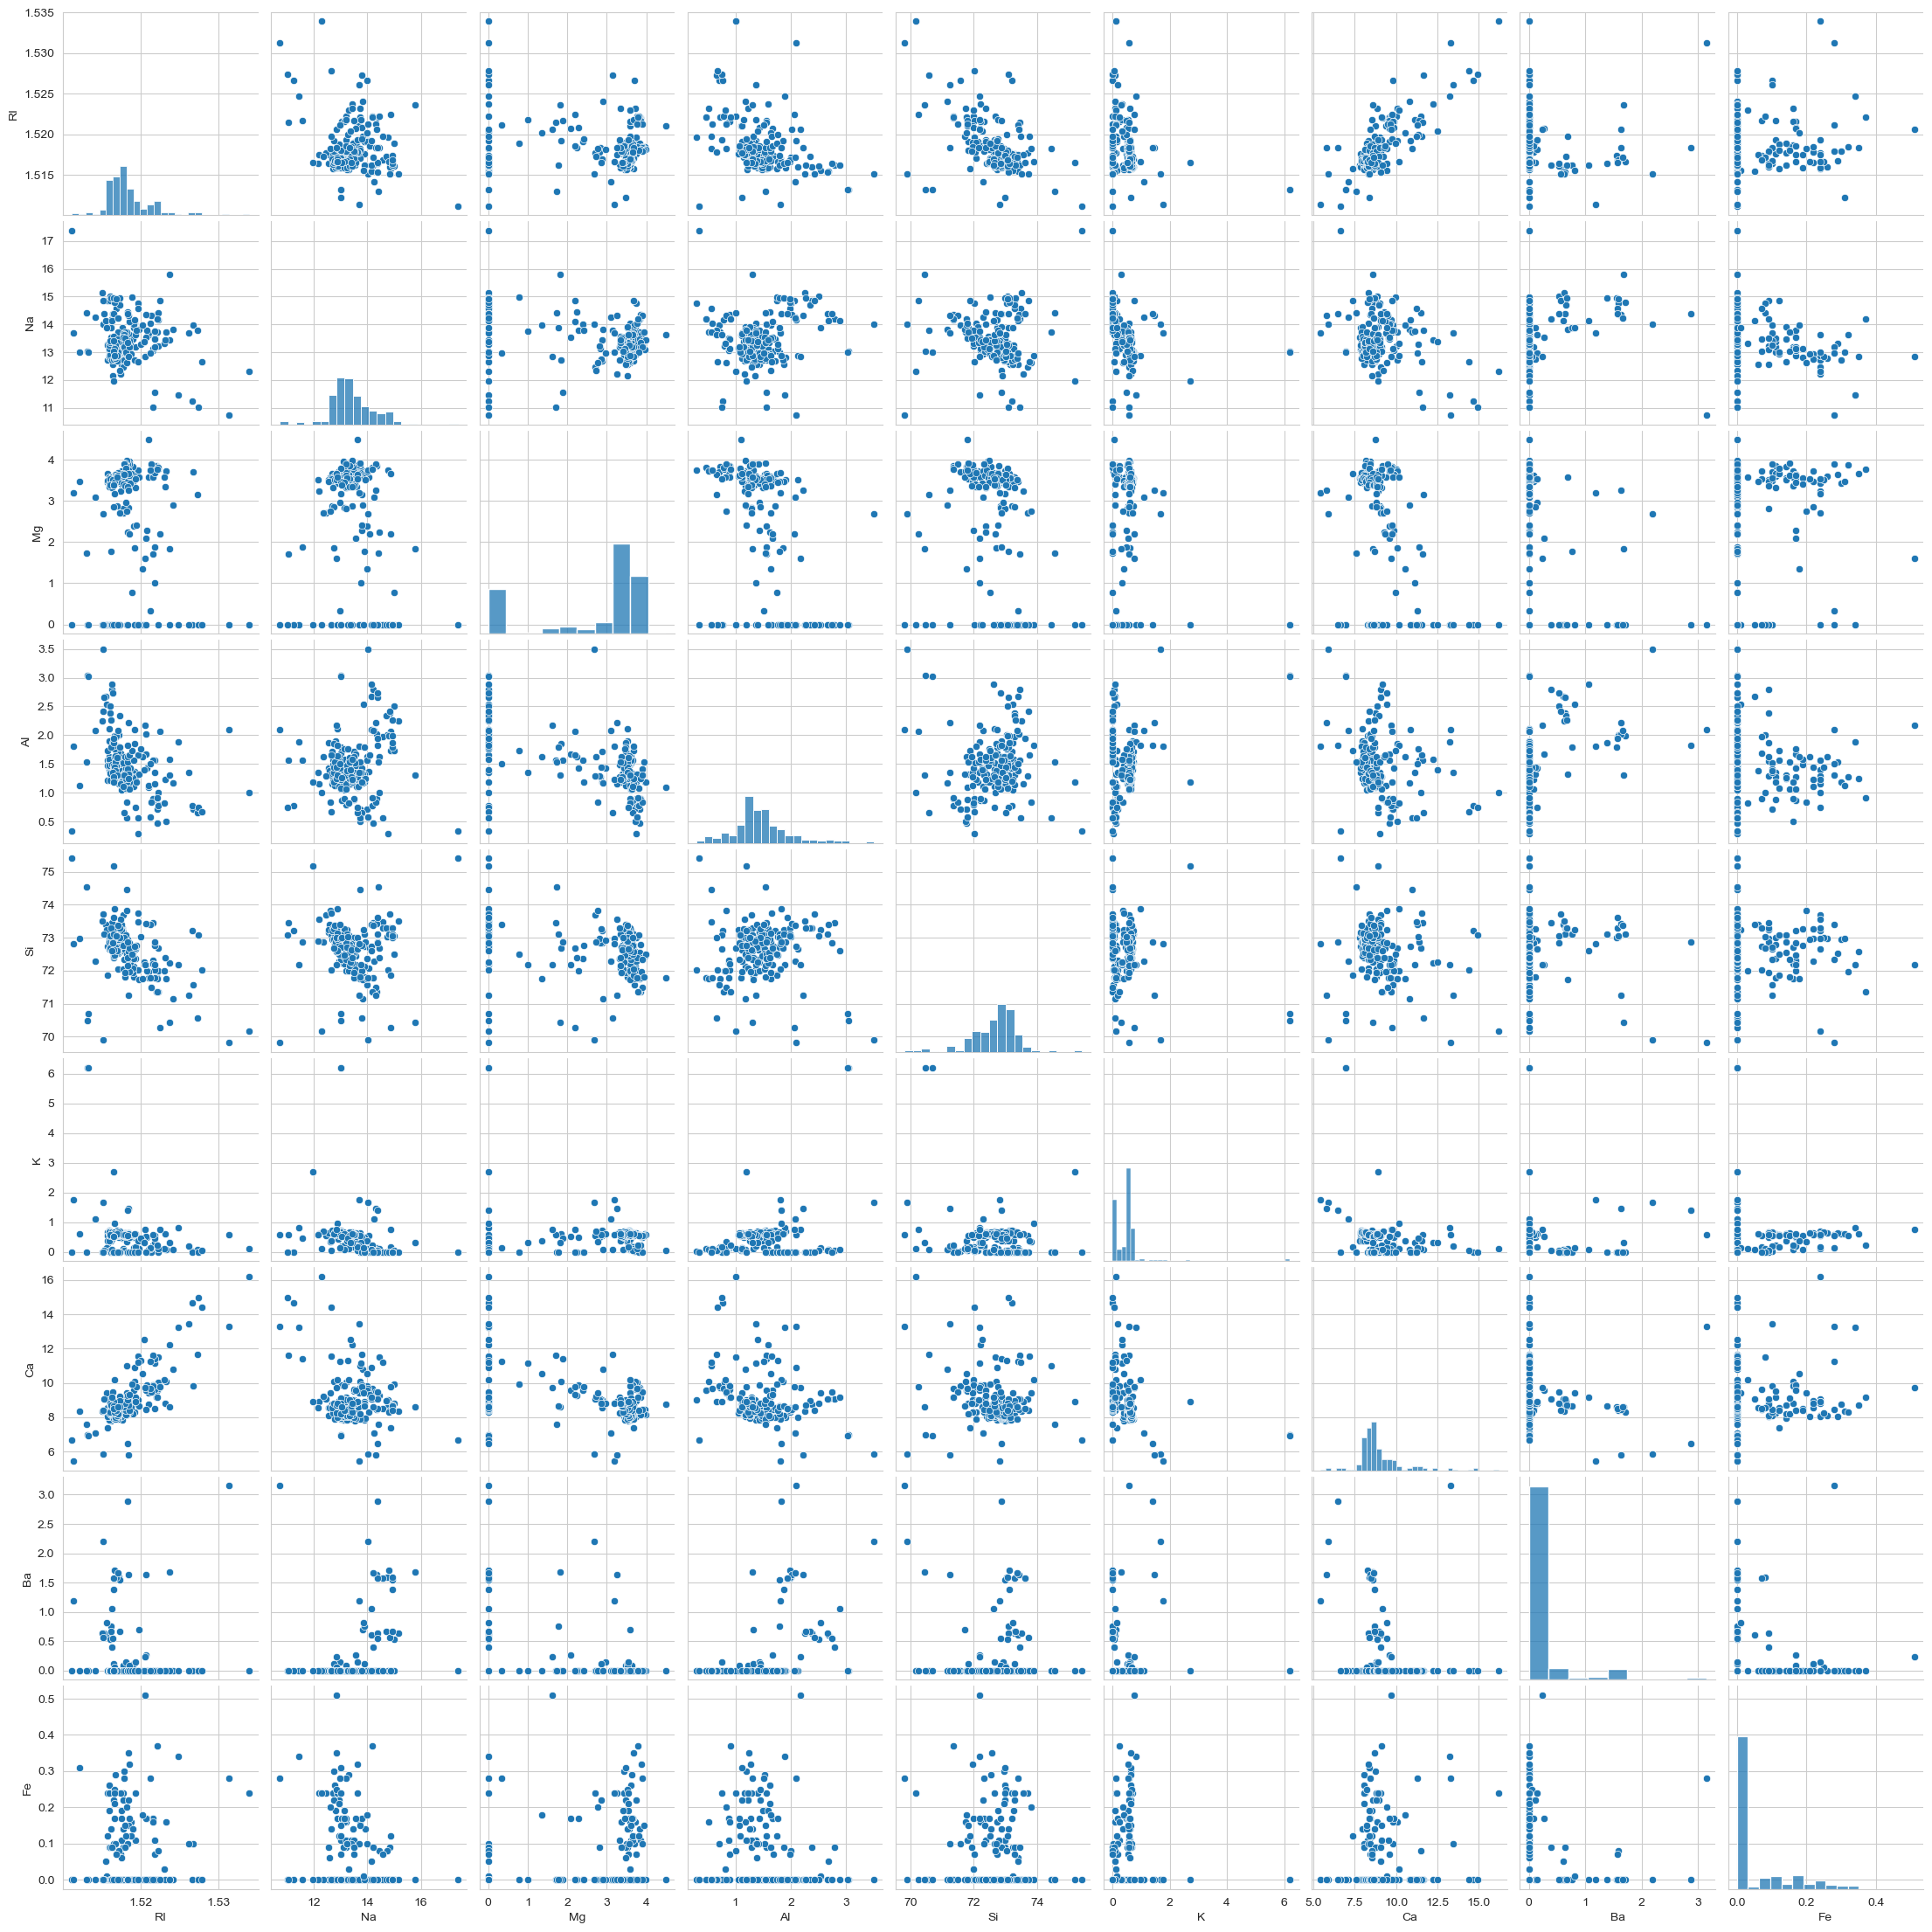

In [34]:
#Plotting a pairplot to visually examine the correlation between the features.
features = glass_df.columns[:-1].tolist()
print(glass_df.shape)
plt.figure(figsize=(9,9))
sns.pairplot(glass_df[features],palette='coolwarm')
plt.show()

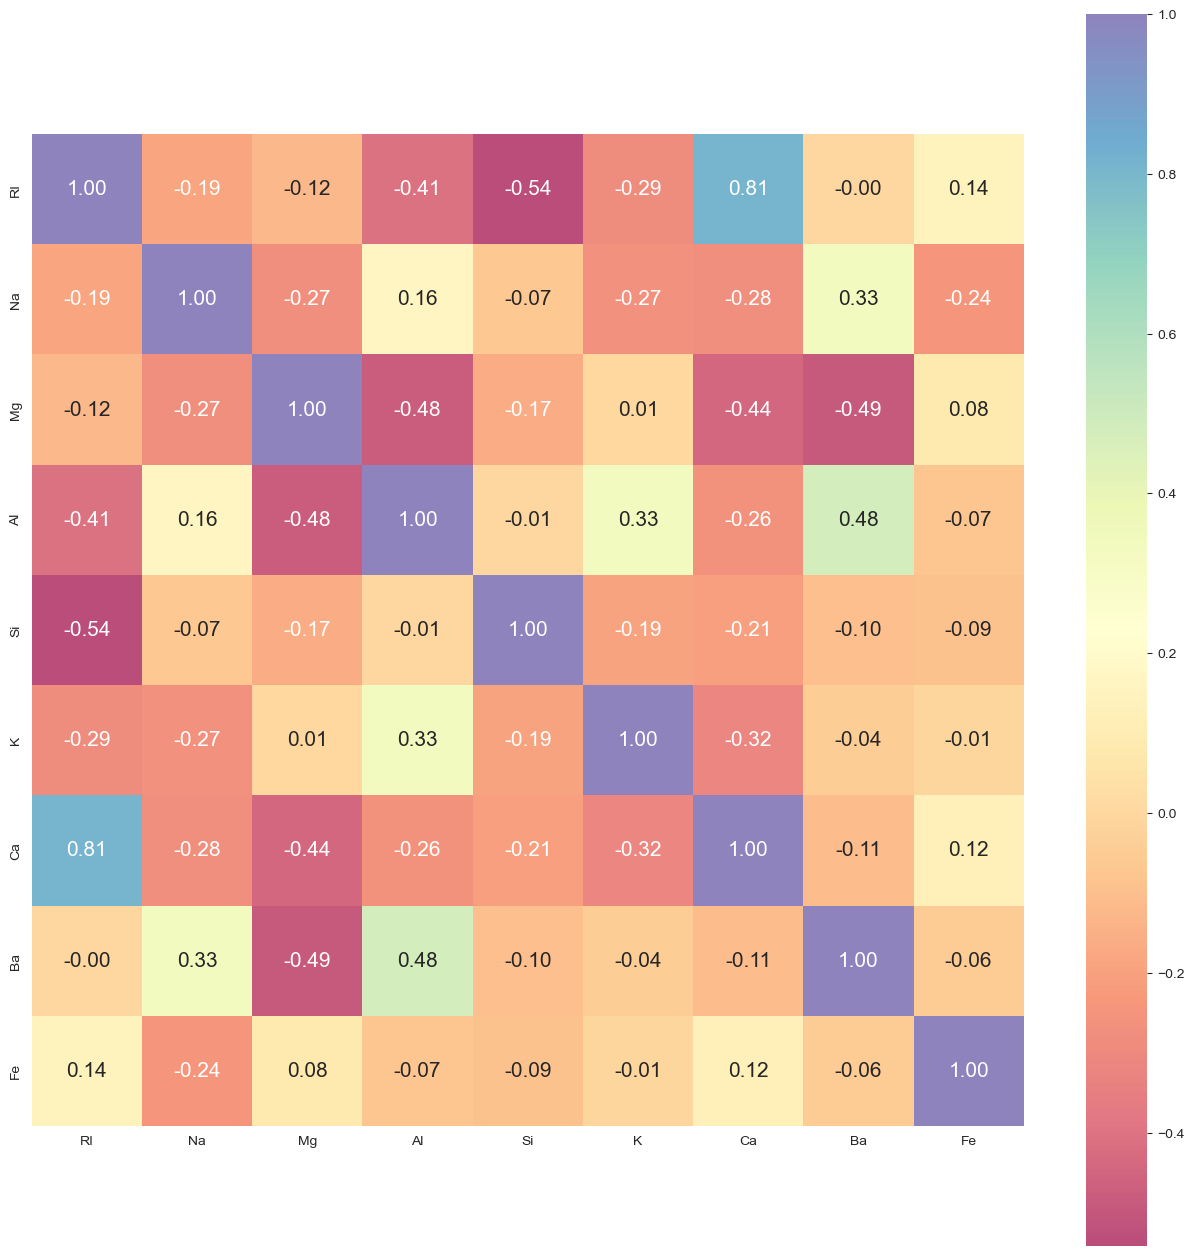

In [35]:
#Plot the heatmap of the correlations 

corr = glass_df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,cmap='Spectral')
plt.show()


<h3>There seems to be a strong positive correlation between RI and Ca.This correlation analysis will have an effect on feature selection. It will be used in order to detach some of the input features.</h3>

<h2>Data Pre-processing and cleaning</h2>

In [36]:
# Check for null entries 
print(glass_df.isnull().sum())


RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


<h3> There are no null entries and missing values in the dataset</h3>

In [37]:
#indentify duplicates any
print("Total number of duplicates identified:", glass_df.duplicated().sum())

# Extract duplicate rows
glass_df.loc[glass_df.duplicated(), :]

Total number of duplicates identified: 1


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


In [38]:
#drop the duplicate rows
glass_df.drop_duplicates(inplace=True)

In [39]:
#print dataframe after removing duplicates
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


<h3> One duplicate record identified and removed.  Now total dataset is 213</h3>

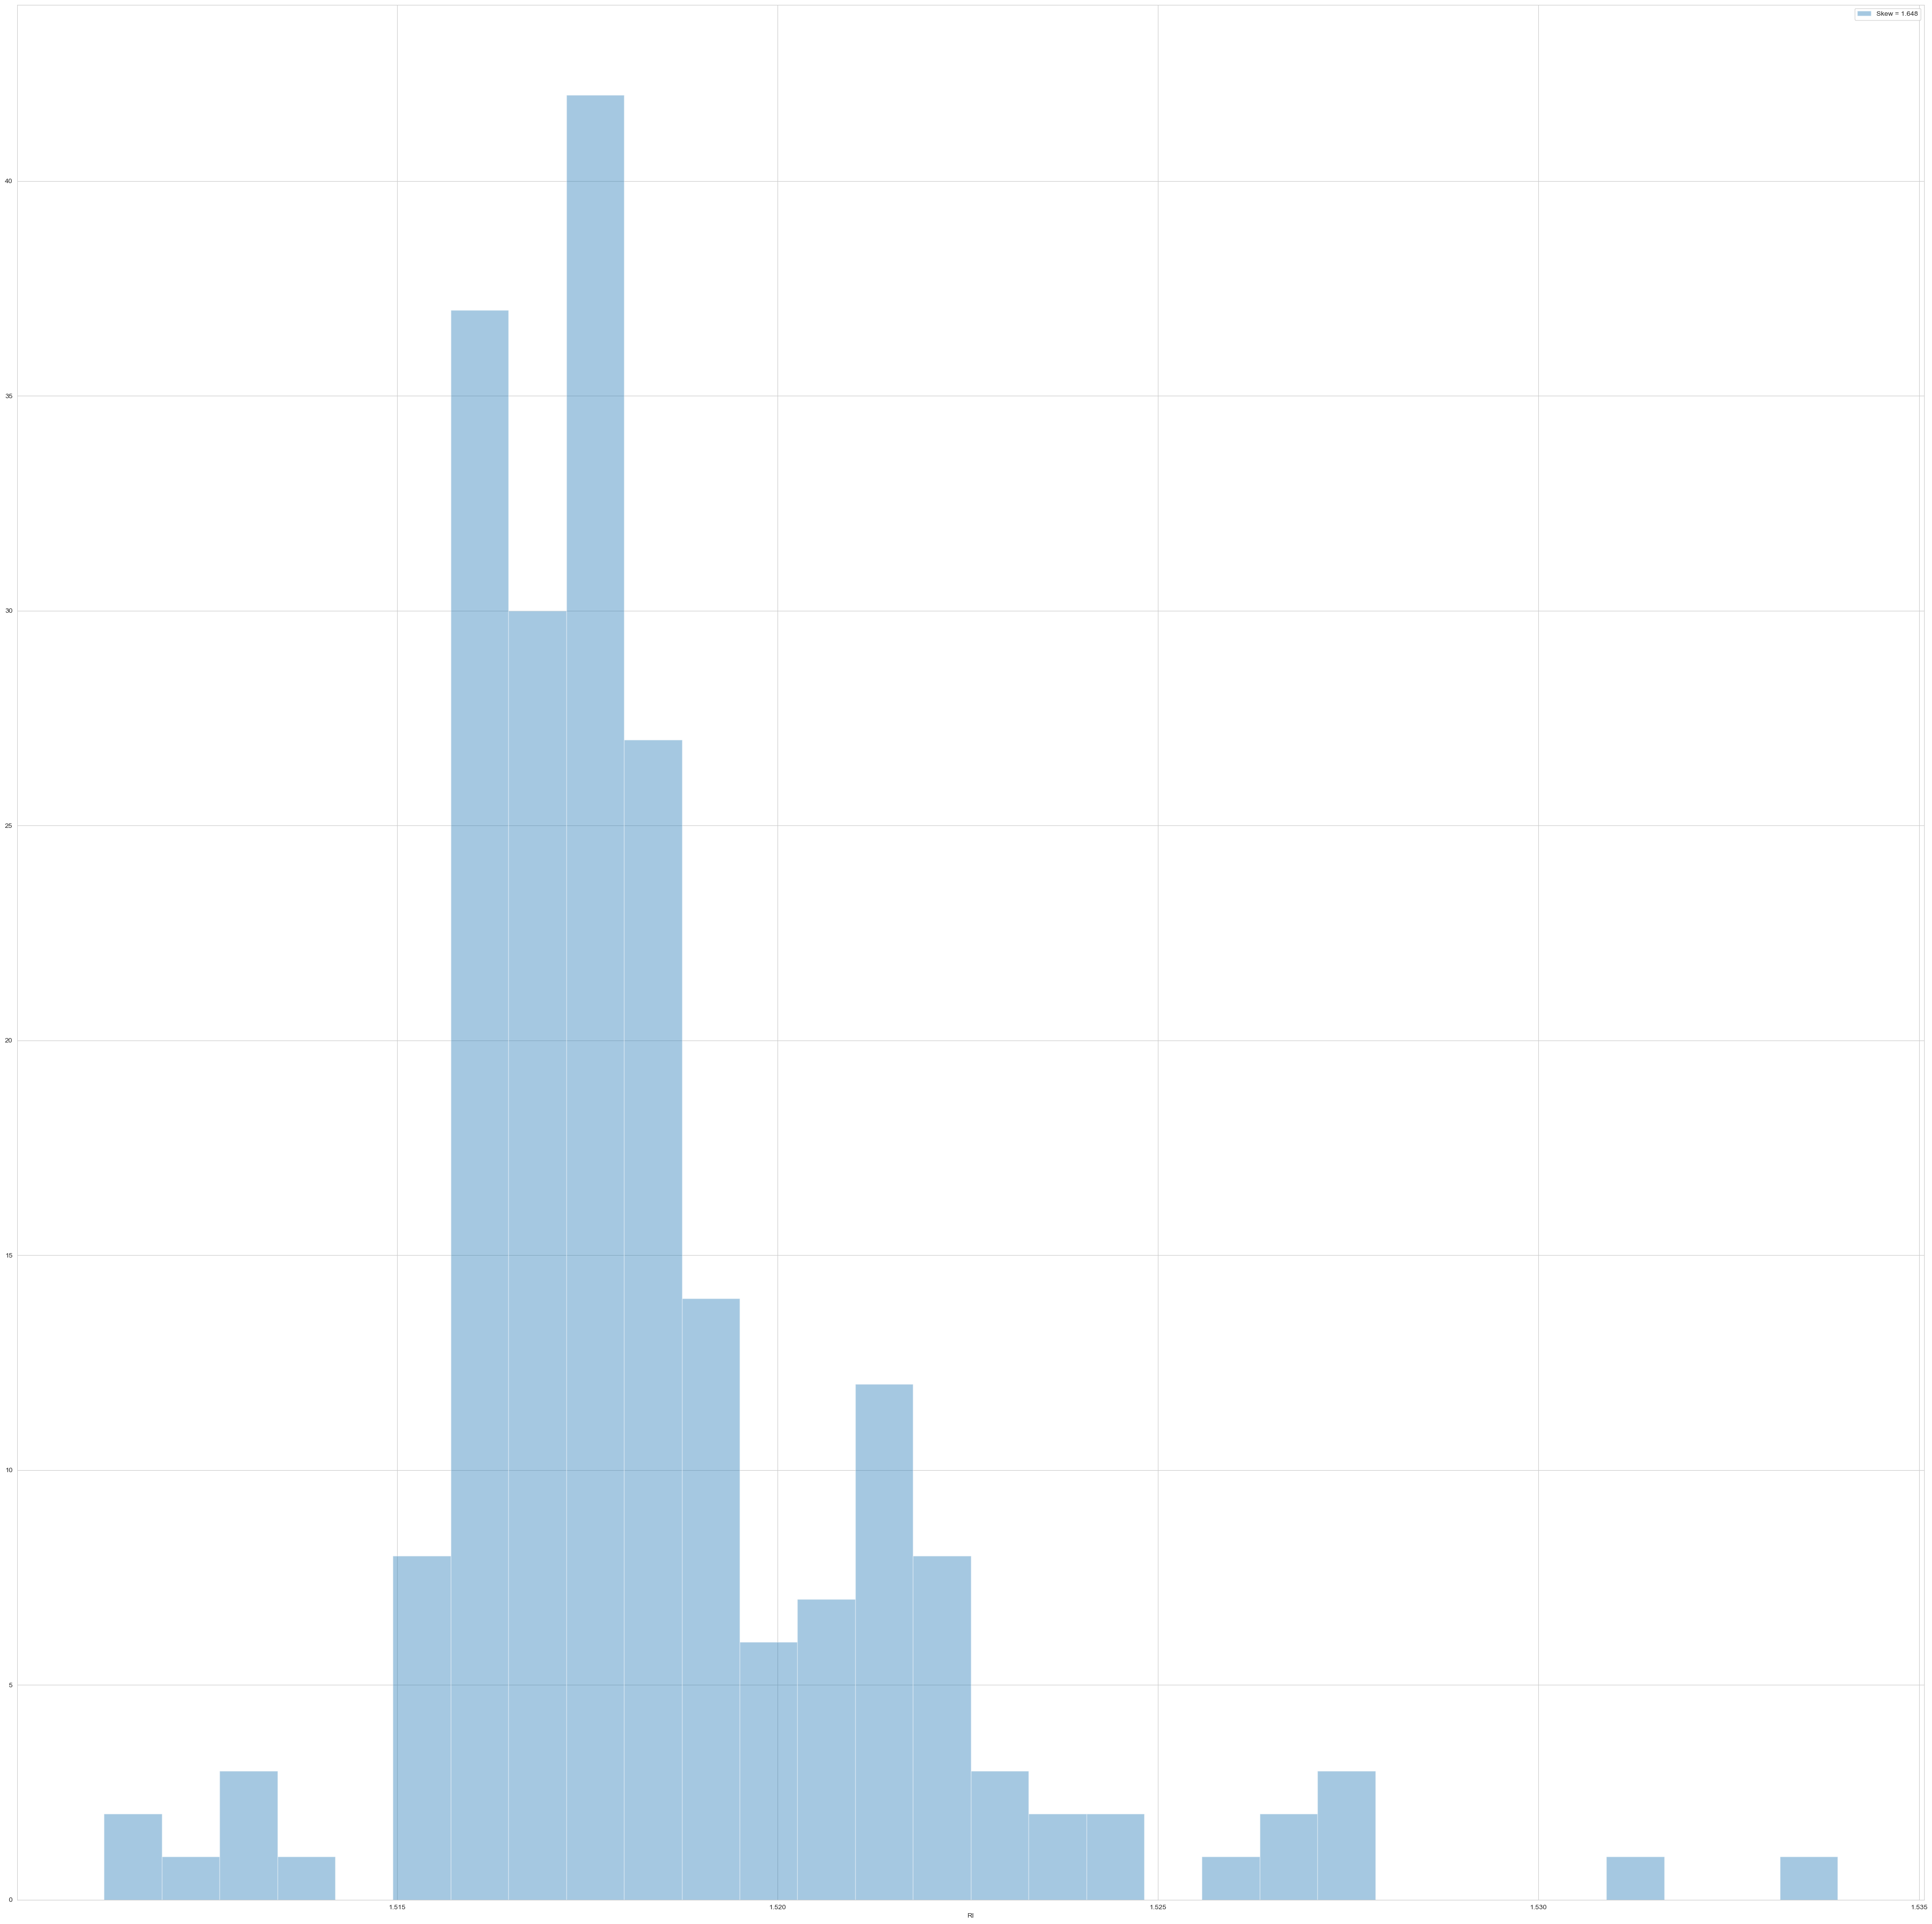

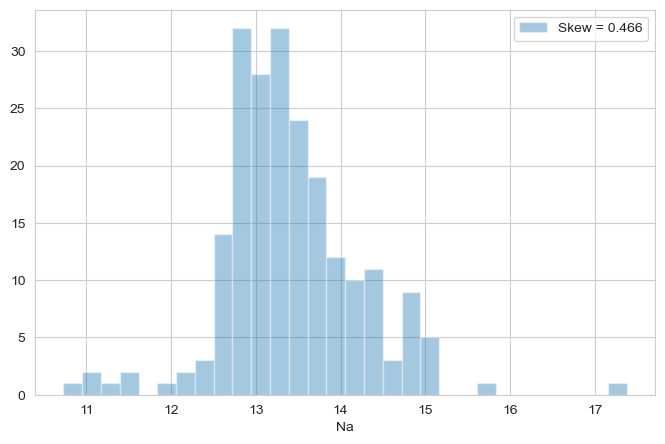

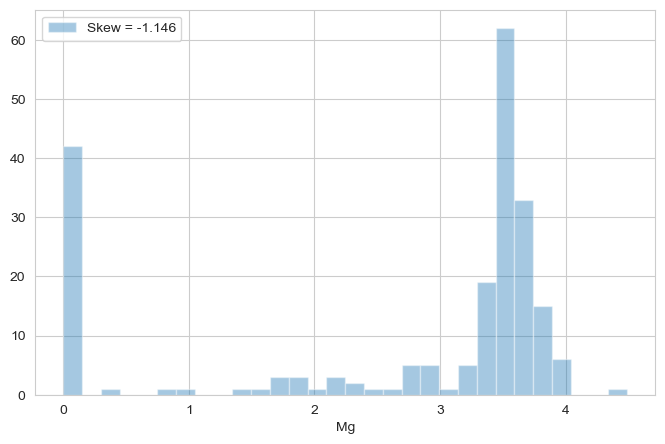

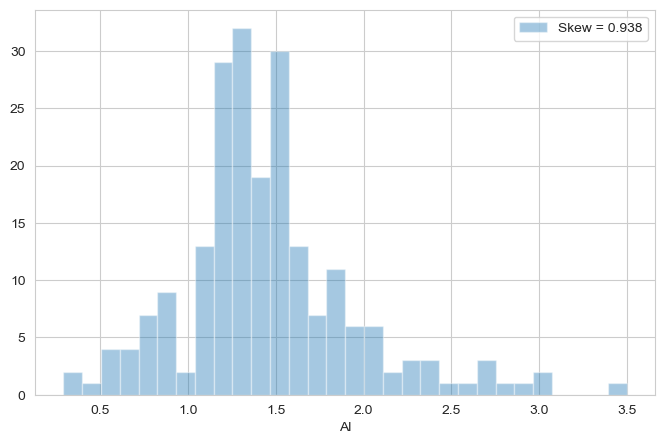

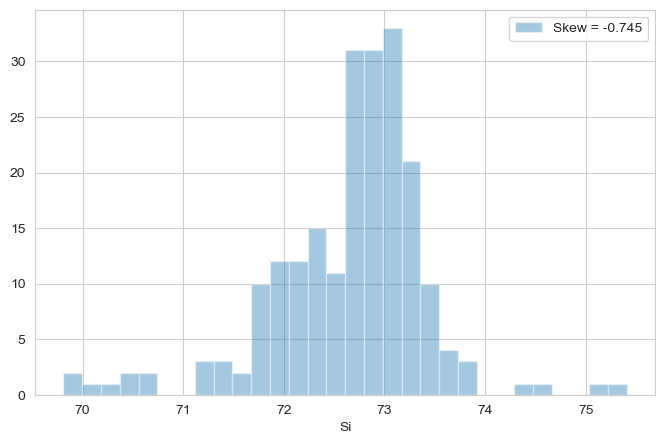

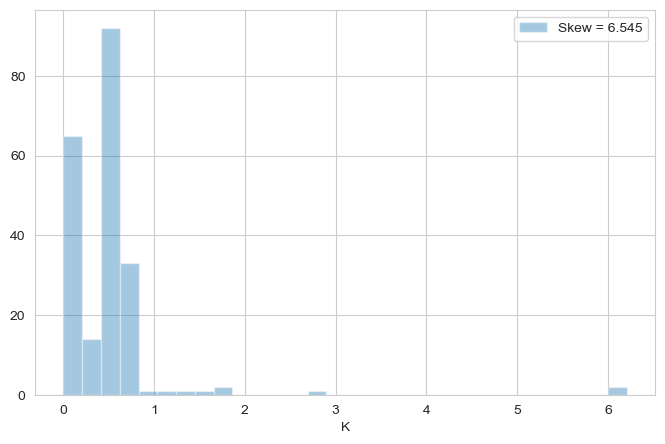

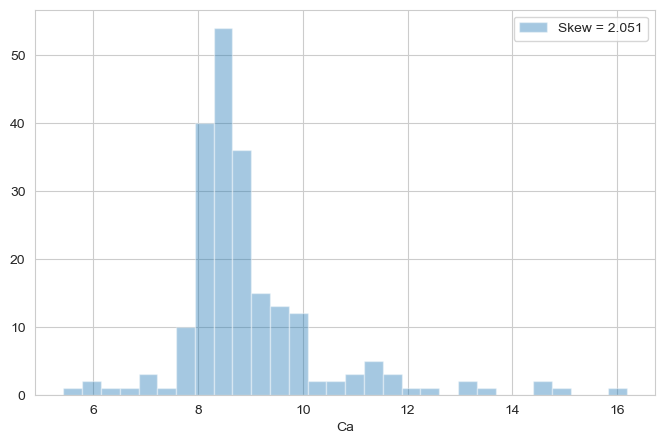

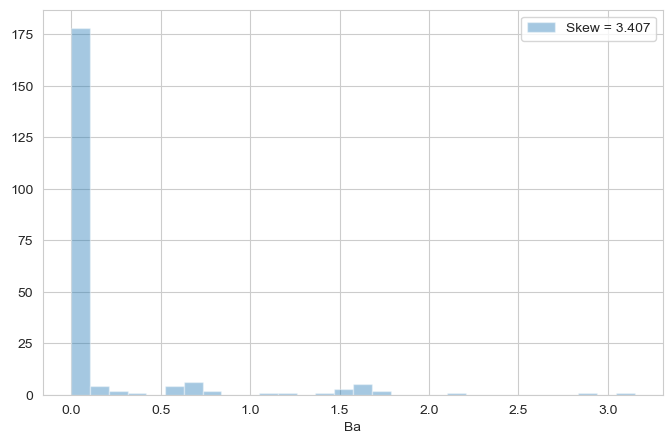

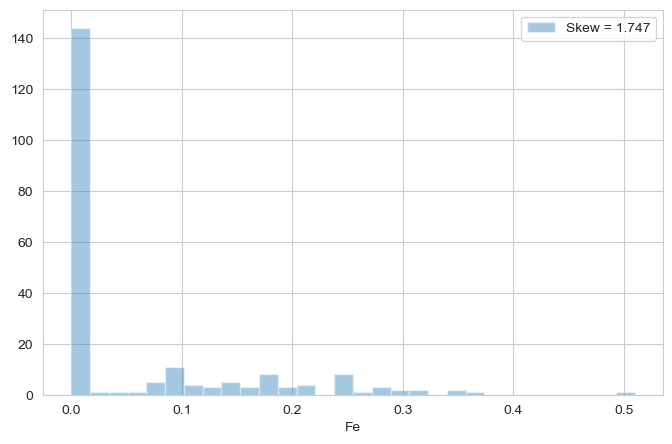

In [40]:
for feat in features:
    skew = glass_df[feat].skew()
    sns.distplot(glass_df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.rcParams["figure.figsize"] = (8,5)
    plt.legend(loc='best')
    plt.show()

<h3> Ri,Fe, Ba, Ca and K shows the highest skew coefficients. None of the variables in the dataset is normally distributed as well</h3>

In [41]:
# Detect data features with more than one outlier

def findoutliers(glassdf):
    outliers = []
    # iterate over features
    for glass_col in glassdf.columns.tolist():
        # Finding 1st quartile (25%)
        Q1_data = np.percentile(glassdf[glass_col], 25)
        
        # Finding 3rd quartile (75%)
        Q3_data = np.percentile(glassdf[glass_col],75)
        
        # Finding Interquartile rrange (IQR)
        IQR = Q3_data - Q1_data
        
        # Finding outlier data
        outlier_data = 1.5 * IQR
        
        # Determine index list of outliers for feature 
        outlier_column = glassdf[(glassdf[glass_col] < Q1_data - outlier_data) | (glassdf[glass_col] > Q3_data + outlier_data )].index
        
        # append to outliers list 
        outliers.extend(outlier_column)
        
    # Finally count outliers which have more than  2 outliers
    outliers = Counter(outliers)        
    Final_outliers = list( k for k, v in outliers.items() if v > 2 )
    
    return Final_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(findoutliers(glass_df[features]))))  

The dataset contains 14 observations with more than 2 outliers


In [42]:
outlier_data = findoutliers(glass_df[features])
glassfinal_df = glass_df.drop(outlier_data).reset_index(drop=True)
print(glassfinal_df.shape)

(199, 10)


<h3> There were 14 outliers identified in the entire dataset with more than 2 outliers and its is removed . Now the final dataset is 199</h3>

In [55]:
#Split-out validation dataset
# Define X as features and y as lablels
from sklearn.preprocessing import LabelEncoder
X = glass_df[features] 
y = glass_df['Type'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


<h3>Standardization is a technique used to convert the statistical distribution of the data into the format mean-0, standard deviation - 1</h3>

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [79]:
#split the data in to 'x' and 'y' and normalise

x=glassfinal_df.drop(columns='Type')
y1=glassfinal_df['Type']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y1)
y1.value_counts() #Check the data is balanced or not 



2    70
1    69
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

  Features  Importances
8       Fe     0.044376
7       Ba     0.079854
4       Si     0.081916
5        K     0.091041
1       Na     0.092798
6       Ca     0.127539
0       RI     0.151575
3       Al     0.164124
2       Mg     0.166777


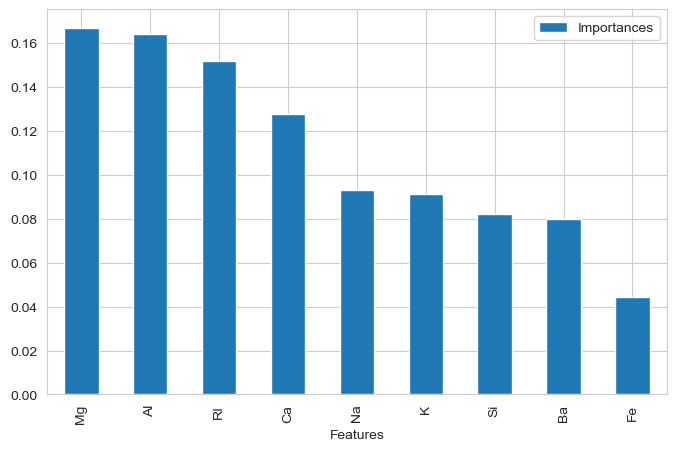

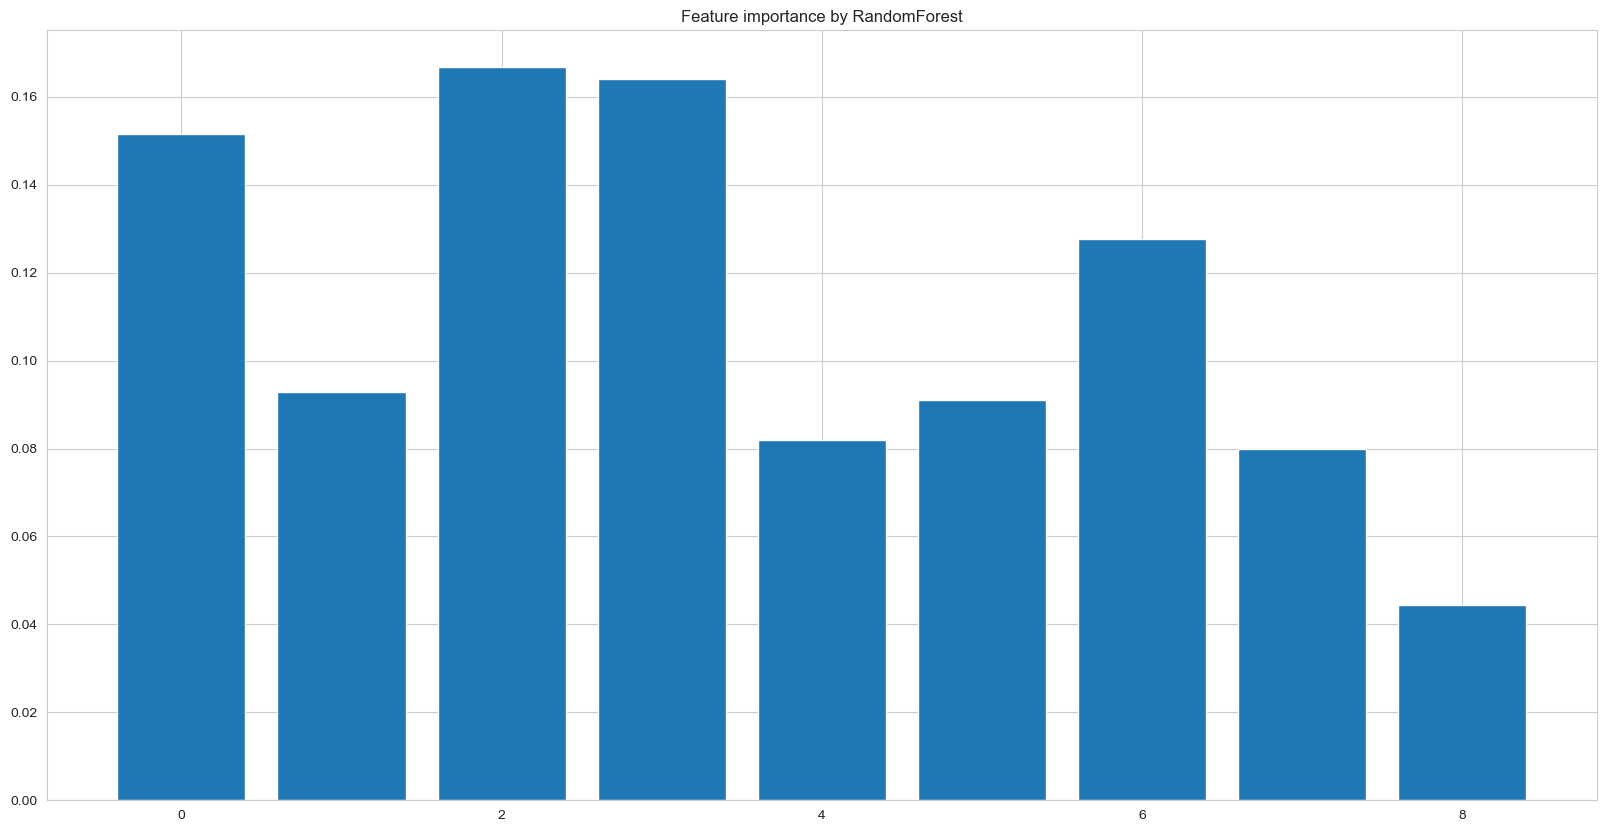

In [63]:
#Feature Importance using RandomForestClassifier technique
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=340)
model.fit(x,y)
importances_random = model.feature_importances_

glass_df_new=pd.DataFrame({"Features": x.columns,"Importances":importances_random})
glass_df_new.set_index('Importances')
glass_df_new= glass_df_new.sort_values('Importances')
print(glass_df_new)
glass_df_new.nlargest(10,'Importances').plot.bar('Features','Importances')

plt.figure(figsize=(20,10))
plt.title('Feature importance by RandomForest')
plt.bar([x for x in range(len(importances_random))],importances_random)
plt.show()

<h3> Random Forest Algorithm : This is a Bagging Algorithm which aggregates a specified number of decision trees. These decrease impurities (Gini Impurity) over all trees & improve purity of then node. At start of the trees, greatest decrease in impurity will be at start of the trees and nodes with the least decrease in impurity occur at the end of trees. This will help in selecting feature of most importance.</h3>

  Features  Importances
4       Si     0.010759
1       Na     0.027533
0       RI     0.032472
5        K     0.036374
2       Mg     0.038989
8       Fe     0.041756
3       Al     0.051319
6       Ca     0.067775
7       Ba     0.693023


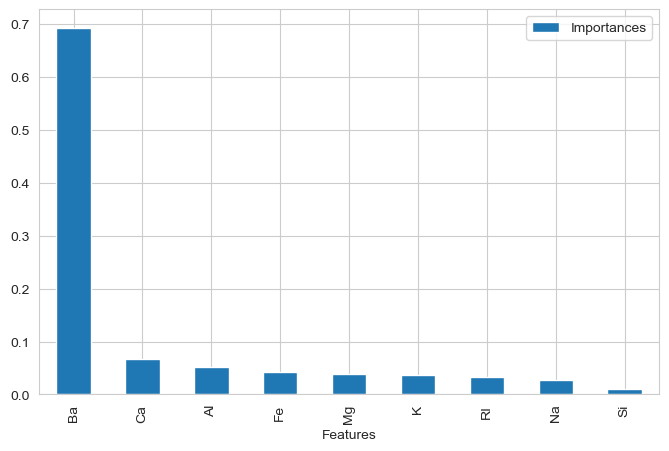

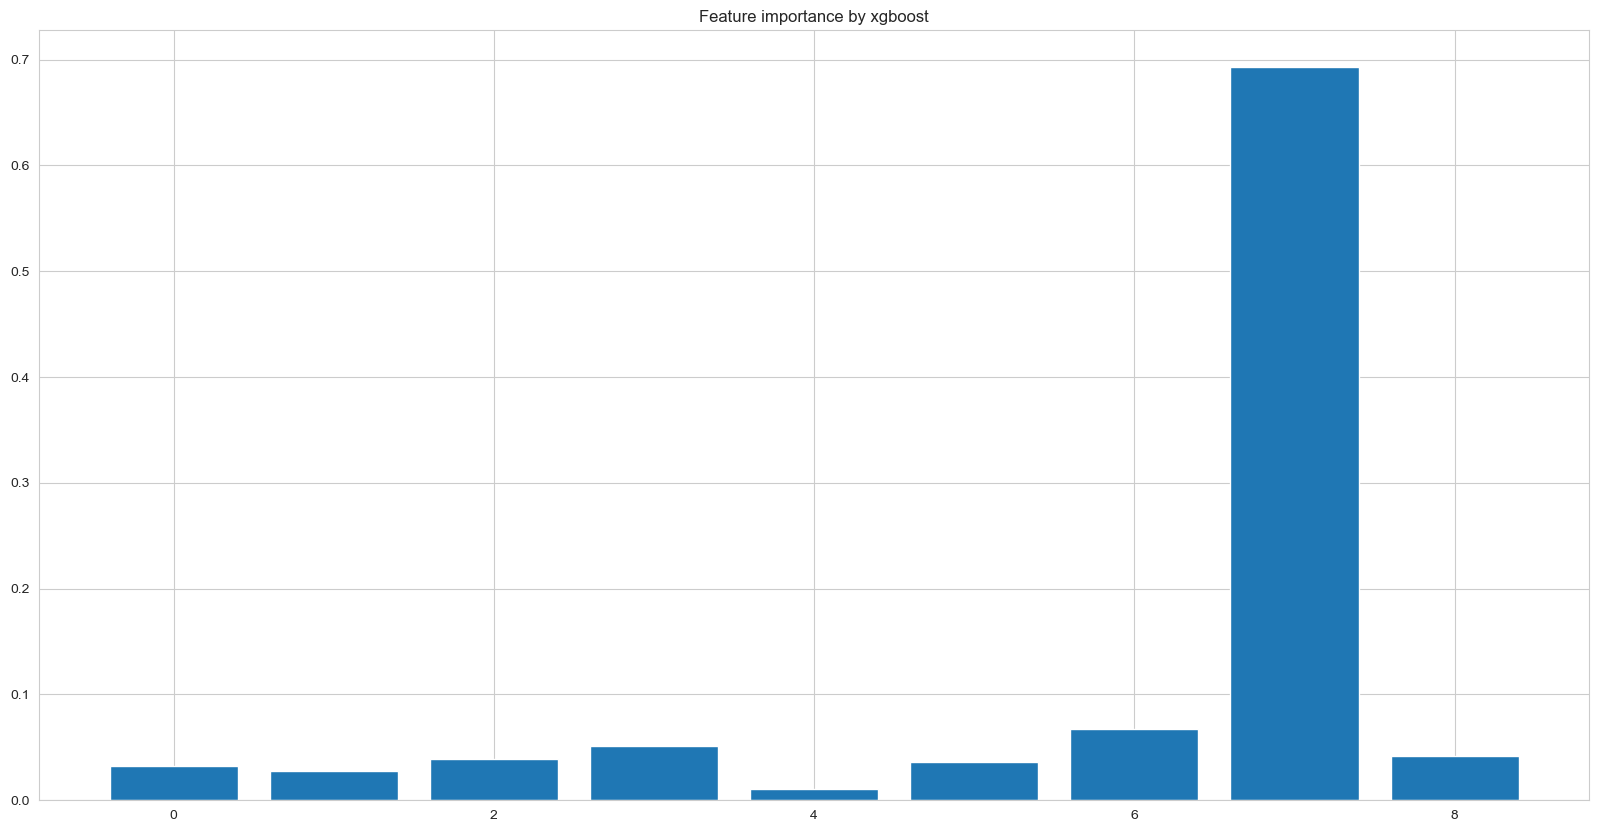

In [64]:
#Feature Importance by xgboost technique
import xgboost
from xgboost import plot_importance
xgb=xgboost.XGBClassifier()
xgb.fit(x,y)

importances=xgb.feature_importances_
columns=x.columns

glass_df_new=pd.DataFrame({"Features": x.columns,"Importances":importances})
glass_df_new.set_index('Importances')
glass_df_new= glass_df_new.sort_values('Importances')
print(glass_df_new)

glass_df_new.nlargest(10,'Importances').plot.bar('Features','Importances')
plt.figure(figsize=(20,10))
plt.title('Feature importance by xgboost')
plt.bar([x for x in range(len(importances))],importances)
plt.show()

<h3> XGBoost Algorithm : Gradient boosting automatically provides estimates of feature importance from a trained predictive model. After boosted trees are constructed, it is easy to retrieve importance scores for each attributes.</h3>

<h2> Model Building </h2>
<h3> Data is split with training -80% and test - 20% so that accuracy of the model algorithm is more. Its defined in earlier section </h3>

In [66]:
#Model building SVM Algorithm
svm = OneVsRestClassifier(SVC(kernel='linear',C = 1,probability=True,random_state=1367))
svm.fit(X_train , y_train)
svm_result = svm.predict(X_test)
SVM_accuracy_score = accuracy_score(y_test , svm_result)
print(classification_report(y_test , svm_result))
print("Classification Accuracy = " + str(accuracy_score(y_test , svm_result)))

              precision    recall  f1-score   support

           1       0.38      0.67      0.48         9
           2       0.56      0.56      0.56        18
           3       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.67      1.00      0.80         6

    accuracy                           0.51        43
   macro avg       0.27      0.37      0.31        43
weighted avg       0.40      0.51      0.44        43

Classification Accuracy = 0.5116279069767442


In [67]:
#Model building Random Forest Algorithm
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200 ,min_samples_split=2 ,
                                                  min_samples_leaf=5, n_jobs=-1,  random_state=1367))
rf.fit(X_train , y_train)
rf_result = rf.predict(X_test)
rf1_result = cross_val_predict(rf, X_train, y_train, cv = 10)
print(cross_val_score(rf, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
rf_accuracy_score = accuracy_score(y_test , rf_result)
print(classification_report(y_test , rf_result))
print("Classification Accuracy = " + str(accuracy_score(y_test , rf_result)))

0.7352941176470588
              precision    recall  f1-score   support

           1       0.43      0.67      0.52         9
           2       0.65      0.72      0.68        18
           3       0.00      0.00      0.00         6
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         2
           7       0.75      1.00      0.86         6

    accuracy                           0.60        43
   macro avg       0.47      0.48      0.45        43
weighted avg       0.51      0.60      0.55        43

Classification Accuracy = 0.6046511627906976


In [68]:
#Model building KNN Algorithm
from sklearn.neighbors import KNeighborsRegressor
knn = OneVsRestClassifier(KNeighborsRegressor(n_neighbors=5))
knn.fit(X_train , y_train)
knn_result = knn.predict(X_test)
knn_accuracy_score = accuracy_score(y_test , knn_result)
print(classification_report(y_test , knn_result))
print("Classification Accuracy = " + str(accuracy_score(y_test , knn_result)))

              precision    recall  f1-score   support

           1       0.50      0.78      0.61         9
           2       0.67      0.78      0.72        18
           3       1.00      0.17      0.29         6
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         2
           7       0.83      0.83      0.83         6

    accuracy                           0.65        43
   macro avg       0.67      0.51      0.52        43
weighted avg       0.69      0.65      0.62        43

Classification Accuracy = 0.6511627906976745


In [69]:
!pip install texttable

Defaulting to user installation because normal site-packages is not writeable


In [70]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Features', 'Accuracy'], ['SVM', SVM_accuracy_score],['KNN', knn_accuracy_score],['Random Forest', rf_accuracy_score]])
print(t.draw())

+---------------+----------+
|   Features    | Accuracy |
+===============+==========+
| SVM           | 0.512    |
+---------------+----------+
| KNN           | 0.651    |
+---------------+----------+
| Random Forest | 0.605    |
+---------------+----------+


<h3> Best fit model : KNN accuracy seems to be greater than other models SVM, Random Forest so the best fit is KNN algorithm for glass classification</h3>

<h2>Performance Evaluation </h2>

In [71]:
# Performance Evaluation  - KFold Cross Validation
from sklearn.pipeline import Pipeline
pipelines = []
pipelines.append( ('SVM',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('SVM', OneVsRestClassifier(SVC(kernel='linear',C = 1,probability=True,random_state=1367)))              
                   ]) ))

pipelines.append( ('KNN',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('KNN', OneVsRestClassifier(KNeighborsRegressor(n_neighbors=5)))              
                   ]) ))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('RF', OneVsRestClassifier(RandomForestClassifier(n_estimators=200 ,min_samples_split=2 ,
                                                  min_samples_leaf=5, n_jobs=-1,  random_state=1367)))              
                   ]) ))


SVM: 55.000000 (+/- 14.491377) performed in 0.091311 seconds
KNN: 67.500000 (+/- 19.137659) performed in 0.063186 seconds
RF: 51.000000 (+/- 12.409674) performed in 9.505914 seconds


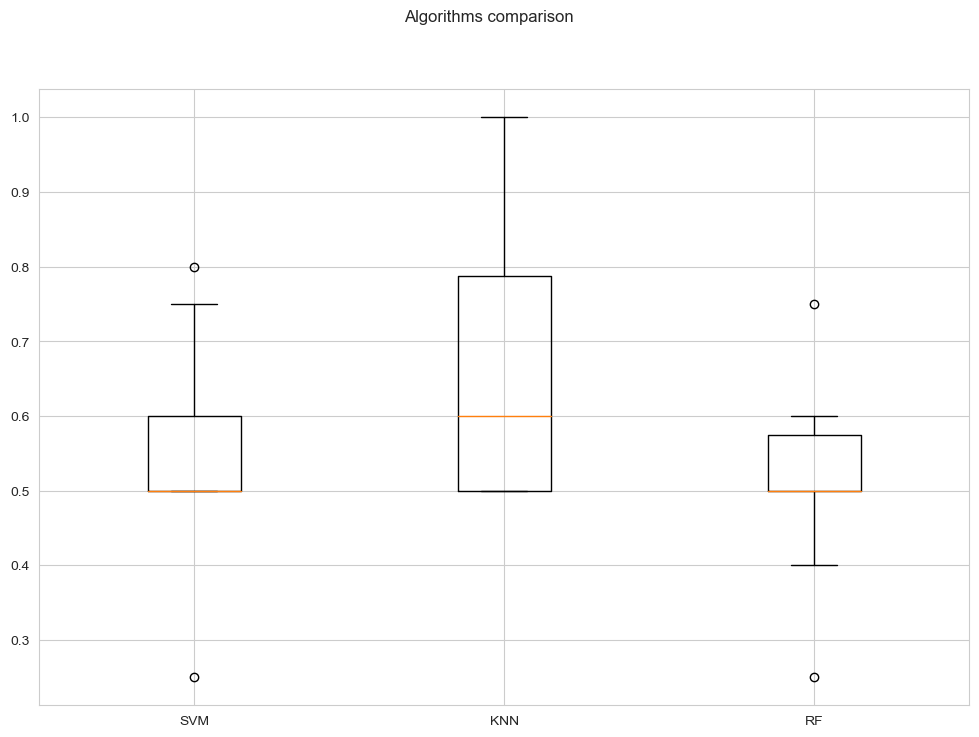

In [72]:
#Plotting boxplot of different models to identify the best fit model
results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds)
    cv_score_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring = scoring) 
    t_elapsed = time() - start
    results.append(cv_score_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_score_results.mean(), 
                                                       100*cv_score_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


<h3>Based on the data above, KNN seems to be best fit performance wise as its accuracy is better compared to other models 
Also for F1 score as well, when compared to other algorithms KNN is better but not ideal one though</h3>

In [73]:
# Performance Evaluation - ROC curve variable initialisation
fpr_svm = {}
tpr_svm = {}
thresh_svm ={}
fpr_rf = {}
tpr_rf = {}
thresh_rf ={}
fpr_knn = {}
tpr_knn = {}
thresh_knn ={}

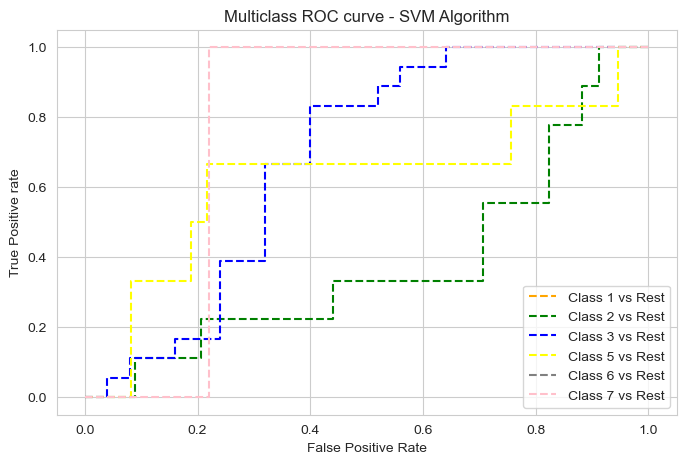

In [74]:
# Performance Evaluation - ROC curve  for SVM algorithm
#Model and train creation for SVM Algorithm
model = OneVsRestClassifier(SVC(kernel='linear',C = 1,probability=True,random_state=1367))
model.fit(X_train,y_train)

#predict the results for test model
predict_svm = model.predict(X_test)
predict_prob_svm = model.predict_proba(X_test)

i=1
n_class_svm = 6

for i in range(n_class_svm):    
    fpr_svm[i], tpr_svm[i], thresh_svm[i] = roc_curve(y_test, predict_prob_svm[:,i], pos_label=i)
# plotting    
plt.plot(fpr_svm[0], tpr_svm[0], linestyle='--',color='orange', label='Class 1 vs Rest')
plt.plot(fpr_svm[1], tpr_svm[1], linestyle='--',color='green', label='Class 2 vs Rest')
plt.plot(fpr_svm[2], tpr_svm[2], linestyle='--',color='blue', label='Class 3 vs Rest')
plt.plot(fpr_svm[3], tpr_svm[3], linestyle='--',color='yellow', label='Class 5 vs Rest')
plt.plot(fpr_svm[4], tpr_svm[4], linestyle='--',color='grey', label='Class 6 vs Rest')
plt.plot(fpr_svm[5], tpr_svm[5], linestyle='--',color='pink', label='Class 7 vs Rest')
plt.title('Multiclass ROC curve - SVM Algorithm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
  


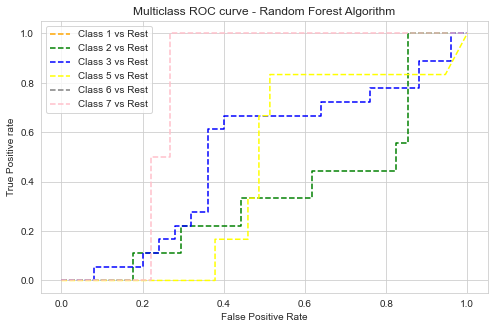

In [43]:
# Performance Evaluation - ROC curve Random Forest Algorithm
#Model and train creation for Random Forest Algorithm
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=200 ,min_samples_split=2 ,
                                                  min_samples_leaf=5, n_jobs=-1,  random_state=1367))
model.fit(X_train,y_train)

#predict the results for test model
predict_rf = model.predict(X_test)
predict_prob_rf = model.predict_proba(X_test)

i=1
n_class_rf = 6

for i in range(n_class_rf):    
    fpr_rf[i], tpr_rf[i], thresh_rf[i] = roc_curve(y_test, predict_prob_rf[:,i], pos_label=i)
# plotting    
plt.plot(fpr_rf[0], tpr_rf[0], linestyle='--',color='orange', label='Class 1 vs Rest')
plt.plot(fpr_rf[1], tpr_rf[1], linestyle='--',color='green', label='Class 2 vs Rest')
plt.plot(fpr_rf[2], tpr_rf[2], linestyle='--',color='blue', label='Class 3 vs Rest')
plt.plot(fpr_rf[3], tpr_rf[3], linestyle='--',color='yellow', label='Class 5 vs Rest')
plt.plot(fpr_rf[4], tpr_rf[4], linestyle='--',color='grey', label='Class 6 vs Rest')
plt.plot(fpr_rf[5], tpr_rf[5], linestyle='--',color='pink', label='Class 7 vs Rest')
plt.title('Multiclass ROC curve - Random Forest Algorithm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')



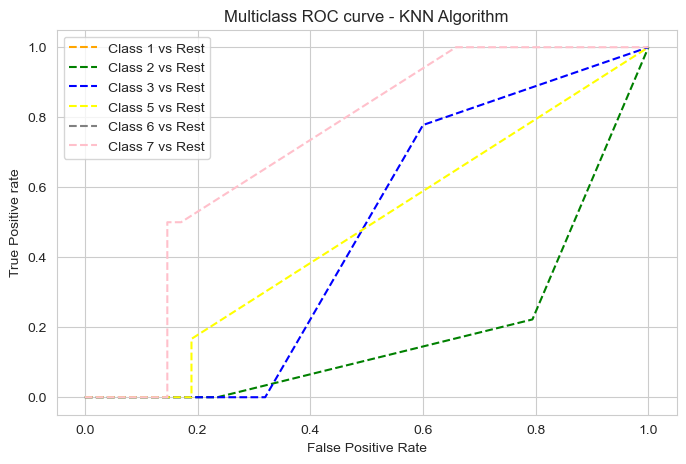

In [75]:
# Performance Evaluation - ROC curve KNN Algorithm
#Model and train creation for KNN Algorithm
model = OneVsRestClassifier(KNeighborsRegressor(n_neighbors=5))
model.fit(X_train,y_train)

#predict the results for test model
predict_knn = model.predict(X_test)

i=1
n_class_knn = 6

for i in range(n_class_knn):    
    fpr_knn[i], tpr_knn[i], thresh_knn[i] = roc_curve(y_test, predict_knn, pos_label=i)
  
# plotting    
plt.plot(fpr_knn[0], tpr_knn[0], linestyle='--',color='orange', label='Class 1 vs Rest')
plt.plot(fpr_knn[1], tpr_knn[1], linestyle='--',color='green', label='Class 2 vs Rest')
plt.plot(fpr_knn[2], tpr_knn[2], linestyle='--',color='blue', label='Class 3 vs Rest')
plt.plot(fpr_knn[3], tpr_knn[3], linestyle='--',color='yellow', label='Class 5 vs Rest')
plt.plot(fpr_knn[4], tpr_knn[4], linestyle='--',color='grey', label='Class 6 vs Rest')
plt.plot(fpr_knn[5], tpr_knn[5], linestyle='--',color='pink', label='Class 7 vs Rest')
plt.title('Multiclass ROC curve - KNN Algorithm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
 


<h3> ROC Curve - For all the three algorithms, not all the classes tends towards the upper left corner of the graph</h3>

In [76]:
#Fine tuning KNN using GridSearchCV

knn = KNeighborsClassifier()
k_range = list(range(1, 50))
num_folds = 10
param_grid = dict(n_neighbors=k_range)
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=num_folds, random_state= None)
gridresult_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)


#Fit the model
start = time()
gridresult_knn = gridresult_knn.fit(X_train, y_train)
end = time()

print("KNN grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(gridresult_knn.best_score_ * 100.0)
print('-------Best params----------')
print(gridresult_knn.best_params_)

Fitting 10 folds for each of 49 candidates, totalling 490 fits
KNN grid search took 0.743 seconds
-------Best score----------
67.64705882352942
-------Best params----------
{'n_neighbors': 1}


In [77]:
# Function to plot curve for Training/Test data scores

def plot_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    glass_train_mean = np.mean(train_scores, axis=1)
    glass_train_std = np.std(train_scores, axis=1)
    glass_test_mean = np.mean(test_scores, axis=1)
    glass_test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, glass_train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,glass_train_mean + glass_train_std,
                    glass_train_mean - glass_train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, glass_test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,glass_test_mean + glass_test_std, glass_test_mean - glass_test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()    
    
  

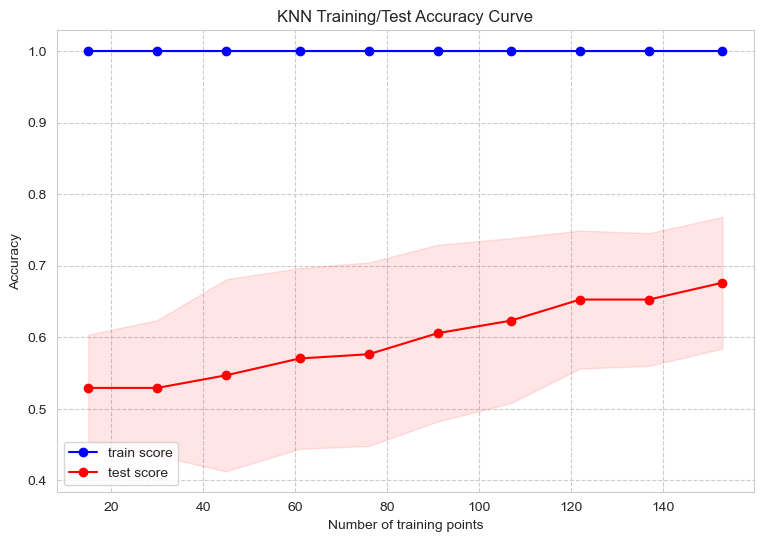

In [78]:
plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= gridresult_knn.best_estimator_ , X= X_train, y = y_train, 
                train_sizes=np.arange(0.1,1.1,0.1), cv= 10,  scoring='accuracy', n_jobs= - 1)

plot_curve(train_sizes, train_scores, test_scores,title = 'KNN Training/Test Accuracy Curve')

<h3> We can clearly see the overfitting problem exists. As train score is always more than test scores.</h3>